In [1]:
import math
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
def elo_probability(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

In [3]:
def calculate_metrics(preds, true_labels):
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(true_labels, preds)
    print("F1 Score:", f1)

    # Calculate recall
    recall = recall_score(true_labels, preds)
    print("Recall:", recall)

    # Calculate precision
    precision = precision_score(true_labels, preds)
    print("Precision:", precision)

In [4]:
with open("../data/training_data/inputs.json", "r") as file:
    X = np.array(json.load(file))
with open("../data/training_data/outputs.json", "r") as file:
    y = np.array(json.load(file), dtype=np.int8)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_original, X_test_original = X_train.copy(), X_test.copy()

scaler = MinMaxScaler()
#X_train, X_test = X_train[:,:2], X_test[:,:2]
X_train, X_test = X_train[:,[0,1,5,6,10,11]], X_test[:,[0,1,5,6,10,11]]
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
n_bins = 20
test = False

In [7]:
# ELO based classifier
elo_probability_preds = []
if test:
    for row in X_test_original:
        elo_probability_preds.append(elo_probability(row[0], row[1]))
    elo_prob_true, elo_prob_pred = calibration_curve(y_test, elo_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(elo_probability_preds), sum(y_test))
else:
    for row in X_train_original:
        elo_probability_preds.append(elo_probability(row[0], row[1]))
    elo_prob_true, elo_prob_pred = calibration_curve(y_train, elo_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(elo_probability_preds), sum(y_train))
elo_preds = [1 if x > 0.5 else 0 for x in elo_probability_preds]

7732.101498602986 8230


In [8]:
# Logistic regression
log_clf = LogisticRegression(random_state=42).fit(X_train, y_train)
if test:
    log_preds = log_clf.predict(X_test)
    log_probability_preds = log_clf.predict_proba(X_test)[:,1]
    log_prob_true, log_prob_pred = calibration_curve(y_test, log_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(log_preds), sum(y_test))
else:
    log_preds = log_clf.predict(X_train)
    log_probability_preds = log_clf.predict_proba(X_train)[:,1]
    log_prob_true, log_prob_pred = calibration_curve(y_train, log_probability_preds, n_bins=n_bins, strategy='quantile')
    print(sum(log_preds), sum(y_train))

9515 8230


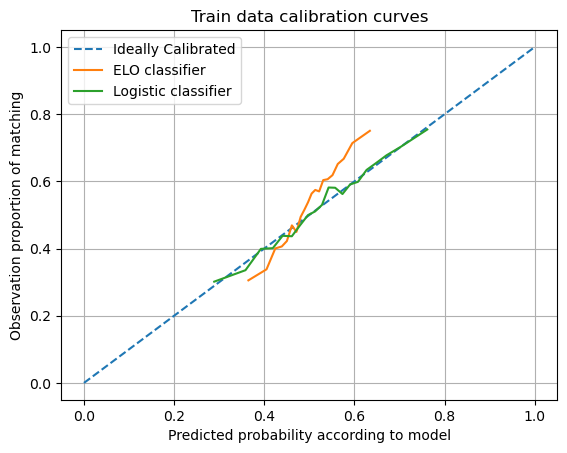

In [9]:
plt.plot([0, 1], [0, 1], linestyle = "--", label = "Ideally Calibrated")
plt.plot(elo_prob_pred, elo_prob_true, label="ELO classifier")
plt.plot(log_prob_pred, log_prob_true, label="Logistic classifier")
if test:
    plt.title("Test data calibration curves")
else:
    plt.title("Train data calibration curves")
plt.xlabel("Predicted probability according to model")
plt.ylabel("Observation proportion of matching")
plt.legend()
plt.grid()
plt.show()

In [10]:
print("Logistic regression metrics:")
if test:
    calculate_metrics(log_preds, y_test)
else:
    calculate_metrics(log_preds, y_train)

print("\nELO model metrics:")
if test:
    calculate_metrics(elo_preds, y_test)
else:
    calculate_metrics(elo_preds, y_train)

Logistic regression metrics:
Accuracy: 0.6052699728084941
F1 Score: 0.6564102564102564
Recall: 0.7076549210206562
Precision: 0.6120861797162375

ELO model metrics:
Accuracy: 0.598795804739091
F1 Score: 0.6136292786333314
Recall: 0.5979343863912515
Precision: 0.6301703163017032


In [11]:
log_clf.coef_, log_clf.intercept_

(array([[ 2.32613295, -2.36118293, -0.15998739, -0.31943401,  0.10460082,
          1.5774392 ]]),
 array([0.09276389]))

In [12]:
pt = np.array([1500,1500,0.5,1,0.5,1]).reshape(1,-1)
log_clf.predict_proba(scaler.transform(pt))

array([[0.47333023, 0.52666977]])

In [13]:
# Save models
with open("../data/model_data/scaler_model.p", "wb") as file:
    pickle.dump(scaler, file)
with open("../data/model_data/main_model.p", "wb") as file:
    pickle.dump(log_clf, file)